In [13]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow.feather as feather
import matplotlib

matplotlib.style.use('ggplot')

### Import the train ready data

In [14]:
labels_df = feather.read_feather('train-ready_data/protein_labels.feather')
sequences_df = feather.read_feather('train-ready_data/protein_sequences.feather')
features_df = feather.read_feather('train-ready_data/proteins_featurized.feather')

### Evaluation metrics

Evaluation metrics for multi-label classification performance are inherently different from those used in multi-class (or binary) classification, due to the inherent differences of the classification problem. If T denotes the true set of labels for a given sample, and P the predicted set of labels, then the following metrics can be defined on that sample:
- Hamming loss: the fraction of the wrong labels to the total number of labels
$$ \frac{1}{|N| \cdot |L|} \sum_{i=1}^{|N|} \sum_{j=1}^{|L|} xor(y_{i,j}, z_{i,j}), $$
where $y_{i,j}$ is the target, $z_{i,j}$ is the prediction, $|N|$ is the number of samples and $|L|$ is the number of labels.
- Jaccard index, the number of correctly predicted labels divided by the union of predicted and true labels $\frac{|T \cap P|}{|T \cup P|}$.
- Precision, recall and $F_1$ score: precision is $\frac{|T \cap P|}{|P|}$, recall is $\frac{|T \cap P|}{|T|}$, and $F_1$ is their harmonic mean.

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, hamming_loss, jaccard_score

def evaluation_report(y_pred, y_true, title=""):
    """
    Compute evaluation metrics for multi-label classification
    """
    # Let's start with basic label specific metrics
    tp = np.sum(y_true * y_pred, axis=0)
    fp = np.sum((1 - y_true) * y_pred, axis=0)
    fn = np.sum(y_true * (1 - y_pred), axis=0)
    tn = np.sum((1 - y_true) * (1 - y_pred), axis=0)

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = precision_score(y_true, y_pred, average=None, zero_division=0)
    recall = recall_score(y_true, y_pred, average=None, zero_division=0)
    f1 = f1_score(y_true, y_pred, average=None, zero_division=0)
    
    fig, ax = plt.subplots(2, 2, figsize=(10, 6), sharex=True, sharey=True)
    ax = ax.flatten()
    
    metrics = [accuracy, precision, recall, f1]
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1']
    for i, metric in enumerate(metrics):
        ax[i].plot(np.arange(len(metric)), metric)
        ax[i].set_xlabel('GO term')
        # Remove xticks
        ax[i].set_xticks([])
        ax[i].set_ylabel('Metric value')
        macro_metric = metric.mean()
        ax[i].set_title(f'Metric: {metric_names[i]} \nMacro average: {macro_metric:.6f}',
                        fontsize=10)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    
    # Calculate the Hamming loss
    hamming = hamming_loss(y_true, y_pred)
    print(f"Hamming loss: {hamming:.6f}.")
    
    # Calculate the Jaccard index
    jacard = jaccard_score(y_true, y_pred, average='macro', zero_division=0)
    print(f"Jaccard index: {jacard.mean():.6f}.")

### Modelling

To start off, we will take the first 10 000 proteins in the train set and only use those to speed up this ad hoc modelling. The real modelling will be done in a separate notebook.

In [16]:
reduced_labels_df = labels_df.iloc[:10000, :]
reduced_train_features = features_df.iloc[:10000, :]

# Check how many proteins have no labels
print(reduced_labels_df.sum(axis=1).value_counts())

3.0      612
5.0      371
10.0     295
9.0      277
8.0      251
        ... 
183.0      1
234.0      1
207.0      1
120.0      1
158.0      1
Name: count, Length: 204, dtype: int64


In [17]:
# Train test split
X_train = reduced_train_features.iloc[:8000, :]
X_test = reduced_train_features.iloc[8000:, :]
y_train = reduced_labels_df.iloc[:8000, :]
y_test = reduced_labels_df.iloc[8000:, :]

### Baseline model

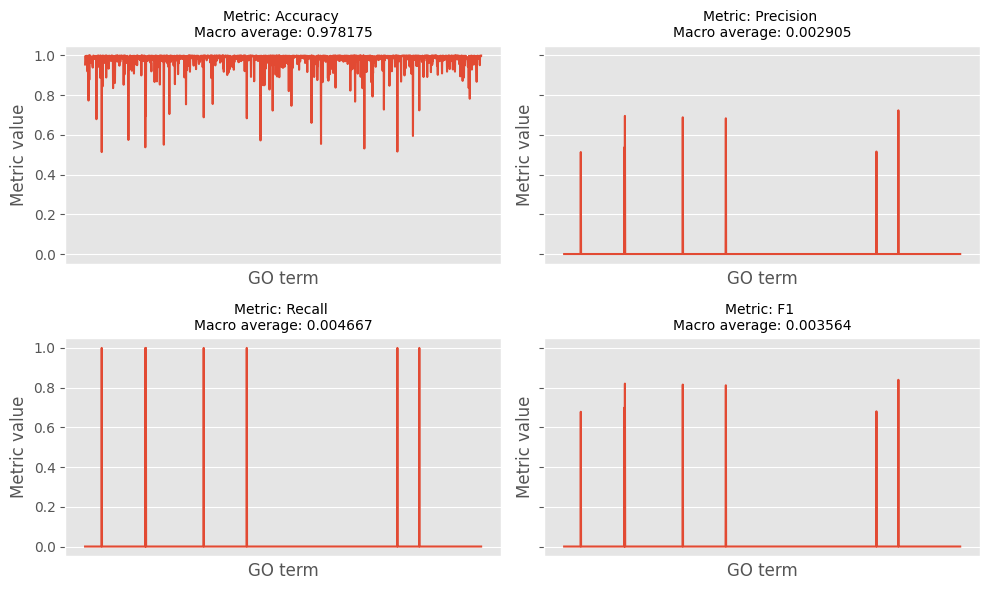

Hamming loss: 0.021825.
Jaccard index: 0.002905.


In [18]:
# Create a simple model that predicts the frequency of each label

class BaseModel:
    def __init__(self, prediction_threshold=0.5):
        self.labels = None
        self.label_frequencies = None
        self.prediction_threshold = prediction_threshold
        
    def fit(self, X, y):
        self.labels = y.columns
        self.label_frequencies = y.sum(axis=0) / y.shape[0]
        
    def predict(self, X):
        return np.tile(self.label_frequencies >= self.prediction_threshold, (X.shape[0], 1))
    
    def predict_proba(self, X):
        return np.tile(self.label_frequencies, (X.shape[0], 1))
    
    def score(self, X, y):
        return (self.predict(X) == y).mean()
    
    def get_params(self, deep=True):
        return {'prediction_threshold': self.prediction_threshold}
    
    def set_params(self, **params):
        self.prediction_threshold = params['prediction_threshold']
        return self
    
base_model = BaseModel()
base_model.fit(X_train, y_train)
test_scores = base_model.score(X_test, y_test)

evaluation_report(base_model.predict(X_test), y_test)

### Simple neural network

Epoch 1/10
200/200 [==============================] - 3s 12ms/step - loss: 0.3803 - accuracy: 0.0170 - val_loss: 0.0900 - val_accuracy: 0.0031
Epoch 2/10
200/200 [==============================] - 2s 12ms/step - loss: 0.1091 - accuracy: 0.0125 - val_loss: 0.0866 - val_accuracy: 0.0056
Epoch 3/10
200/200 [==============================] - 2s 10ms/step - loss: 0.0989 - accuracy: 0.0130 - val_loss: 0.0895 - val_accuracy: 0.0019
Epoch 4/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0940 - accuracy: 0.0150 - val_loss: 0.0842 - val_accuracy: 0.0037
Epoch 5/10
200/200 [==============================] - 2s 10ms/step - loss: 0.0924 - accuracy: 0.0166 - val_loss: 0.0839 - val_accuracy: 0.0106
Epoch 6/10
200/200 [==============================] - 2s 10ms/step - loss: 0.0905 - accuracy: 0.0153 - val_loss: 0.0826 - val_accuracy: 0.0225
Epoch 7/10
200/200 [==============================] - 2s 11ms/step - loss: 0.0891 - accuracy: 0.0162 - val_loss: 0.0843 - val_accuracy: 0.0213


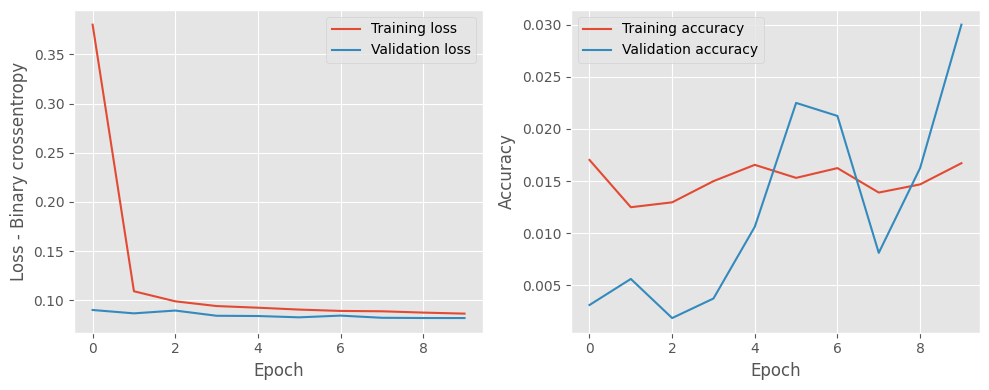

63/63 [==============================] - 0s 3ms/step


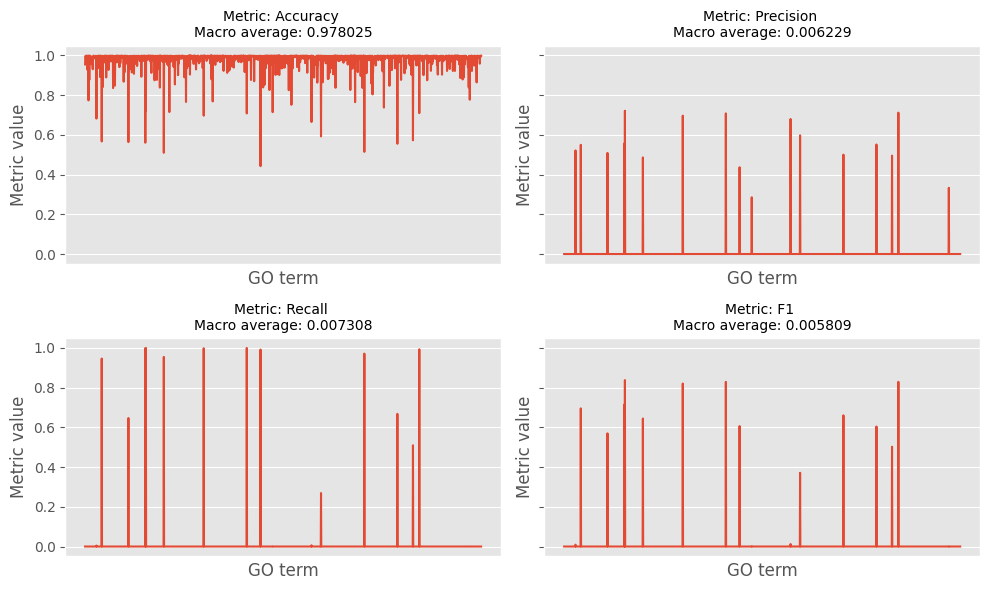

Hamming loss: 0.021975.
Jaccard index: 0.004491.


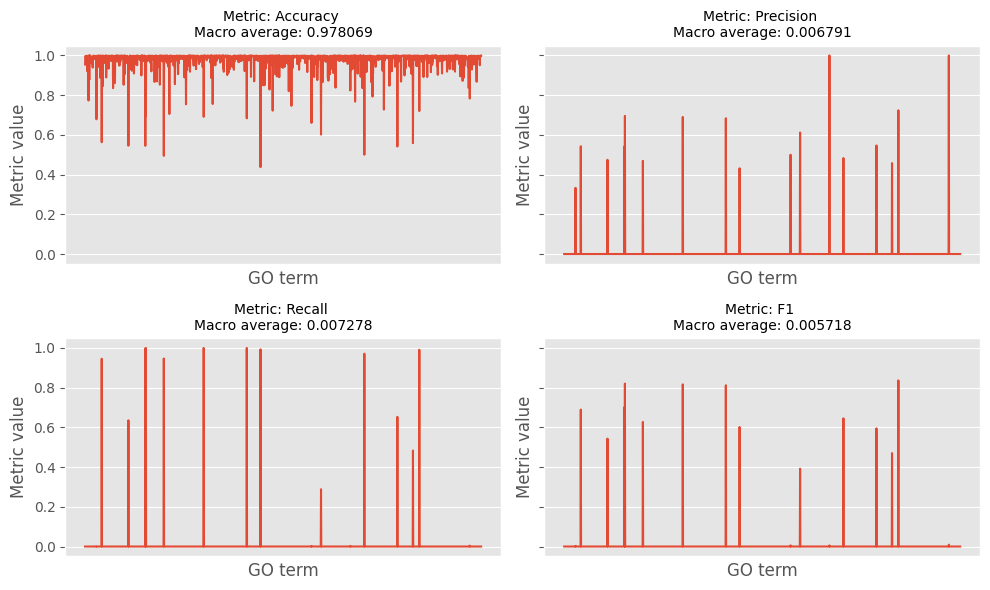

Hamming loss: 0.021931.
Jaccard index: 0.004386.


In [19]:
import tensorflow as tf

# Build a simple neural network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(y_train.shape[1], activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
results = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Plot the training and validation loss
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(results.history['loss'], label='Training loss')
ax[0].plot(results.history['val_loss'], label='Validation loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss - Binary crossentropy')
ax[0].legend()

ax[1].plot(results.history['accuracy'], label='Training accuracy')
ax[1].plot(results.history['val_accuracy'], label='Validation accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
plt.tight_layout()
plt.show()

# Get predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluate the train set
evaluation_report(y_train_pred >= 0.5, y_train, title='Train set performance')
# Evaluate the test set
evaluation_report(y_test_pred >= 0.5, y_test, title='Test set performance')